In [1]:
# If you get some import-related errors, you may need to put the packages into the PYTHONPATH (see Readme for related packages)

from trex import TrexClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
import logging
from IPython import display

%load_ext autoreload
%autoreload 2

In [2]:
logging.basicConfig(level=logging.INFO)

## Prepare data

In [3]:
# Load the data
data = pd.read_csv('data/titanic.csv')

In [4]:
# Notice how we have categorical and numerical data
data.head()

,Pclass,Sex,SibSp,Parch,Ticket,Fare,Embarked,Age,Survived,name_length
0,3.0,male,1.0,0.0,21171,7.2500,S,22.0,no,23
1,1.0,female,1.0,0.0,17599,71.2833,C,38.0,yes,51
2,3.0,female,0.0,0.0,3101282,7.9250,S,26.0,yes,22
3,1.0,female,1.0,0.0,113803,53.1000,S,35.0,yes,44
4,3.0,male,0.0,0.0,373450,8.0500,S,35.0,no,24


In [5]:
# split data into training / test
X_train, X_test, y_train, y_test = train_test_split(data.drop('Survived', axis=1), data['Survived'], test_size=0.2, random_state=42)
## Train model

In [6]:
# Create a TrexClassifier object
# we explain briefly each value
trex = TrexClassifier(
    # Maximum(!) amount of decision trees which will be trained (ensemble size)
    # more trees potentially mean a higher amount of rules
    # the algorithm will early stop if necessary 
    # You should increase / decrease this number if your data is very complex / simple
    max_experts=10, # default is 10
    
    # how big a tree can grow at maximum 
    # The more levels, the more complex the rules can be
    # but the more lengthy they may become
    # You should increase / decrease this number if your data is very complex / simple
    max_expert_depth=2, # default is 2
    
    # assignment trees will model the specialization of each expert (which data it is good at)
    # same logic as `max_expert_depth`
    max_assignment_depth=3, # default is 2
    
    # Stop growing the tree if node would have lesser samples than this
    # the lower the number, the more complex the rules can be
    # and the higher the chance of overfitting
    # if your data set is big, you may want to increase this number
    min_samples_at_leaf=3, # default is 3
    
    # Throw away rules which are not matching at least a proportion of the data
    # A higher number will yield lesser rules, but may hide interesting patterns
    # If you want to mine information, you may want to set this to a lower value
    # If you want to have a more robust model, easy to interpret, you may want to set this to a higher value
    min_rule_coverage=0.01, # default is 0.01
    
    # Throw away rules which for which the precision falls below this threshold
    # same logic as `min_rule_coverage` applies
    min_rule_precision=0.5, # default is 0.5
    
    # For display purposes. Can be omitted if your data is passed as a DataFrame having column names
    feature_names=None, # default is None
    
    # For display purposes. Can be omitted if your data is passed as a pandas Series having a name 
    target_name=None, # default is None
    
    # Rules can sometimes be pruned (shortened) without a hard penalty on the model performance 
    # This may decrease the number as well as the complexity of rules in the rule system 
    # if `simplify_rules` is set to True, the rules will be simplified if this condition is met
    # if you want to mine patterns, you may want to set this to False
    simplify_rules=True, # default is True
)

In [7]:
trex.fit(X_train, y_train)

INFO:TrexClassifier:Training step 1 of 10
INFO:TrexClassifier:Training step 2 of 10
INFO:TrexClassifier:Training step 3 of 10
INFO:TrexClassifier:All data points are already assigned. Stopping early with 2 experts.
INFO:TrexClassifier:Generating Rules
INFO:TrexClassifier:Generate Assignment Trees


In [14]:
print("The explanation shows a rule set where each entry can be read from left to right connected by an `AND` ")
print("Additionally the Coverage and precision of each entry is shown, alongside the expert number which was used as source.")
trex.explain()

The explanation shows a rule set where each entry can be read from left to right connected by an `AND` 
Additionally the Coverage and precision of each entry is shown, alongside the expert number which was used as source.


,Rule 1,Rule 2,Rule 3,Rule 4,Coverage in Percent,Precision in Percent,Expert,Prediction
0,"Age is INSIDE range [16.00, ..., 80.00[",Ticket ≥ 17582.0,Sex matches value female,,19.41,80.43,#1,yes
1,"Age is INSIDE range [16.00, ..., 80.00[",Ticket < 17582.0,"Fare is OUTSIDE range [26.29, ..., 69.55[",Sex matches value female,8.44,65.00,#1,yes
2,"Age is INSIDE range [16.00, ..., 80.00[",Ticket < 17582.0,"Fare is INSIDE range [26.29, ..., 69.55[",Sex is not female,3.66,65.38,#2,yes
3,"Ticket is INSIDE range [29103.30, ..., 382652.00[",Sex is not female,Age < 3.6,,2.11,80.00,#2,yes
4,"Age is OUTSIDE range [16.00, ..., 80.00[",Sex matches value female,"Ticket is INSIDE range [2653.00, ..., 29103.30[",,1.55,90.91,#1,yes
5,"Age is INSIDE range [16.00, ..., 80.00[",Ticket ≥ 17582.0,Sex is not female,,44.16,88.22,#1,no
6,"Age is INSIDE range [16.00, ..., 80.00[",Ticket < 17582.0,"Fare is OUTSIDE range [26.29, ..., 69.55[",Sex is not female,13.22,78.72,#1,no
7,"Age is OUTSIDE range [16.00, ..., 80.00[",Sex is not female,Ticket < 2315.0,,2.39,82.35,#1,no
8,"Ticket is INSIDE range [29103.30, ..., 382652.00[",Sex matches value female,Age < 3.6,,1.97,64.29,#2,no


In [37]:
trex.explain_datapoints(data_points=X_test.iloc[5:10, :])

,Rule 1,Rule 2,Rule 3,Rule 4,Precision in %,Coverage in %,Expert,Survived
0,"Age is INSIDE range [16.00, ..., 80.00[",Ticket ≥ 17582.0,Sex is not female,,88.22,44.16,1,no
1,"Age is INSIDE range [16.00, ..., 80.00[",Ticket ≥ 17582.0,Sex is not female,,88.22,44.16,1,no
2,"Age is INSIDE range [16.00, ..., 80.00[",Ticket ≥ 17582.0,Sex is not female,,88.22,44.16,1,no
3,"Age is INSIDE range [16.00, ..., 80.00[",Ticket < 17582.0,"Fare is OUTSIDE range [26.29, ..., 69.55[",Sex matches value female,65.00,8.44,1,yes
4,"Age is INSIDE range [16.00, ..., 80.00[",Ticket ≥ 17582.0,Sex matches value female,,80.43,19.41,1,yes


In [41]:
print("Test set performance:", trex.score(X_test, y_test))
print("Train set performance:", trex.score(X_train, y_train))

Model performance
Test set performance: 0.7921348314606742
Train set performance: 0.8045007032348804


In [39]:
# you can also calculate the coverage of the rules
# i.e., how many samples have been covered by the rules
print("Rule coverage on test set:", trex.rule_loe_.calculate_rule_coverage(X_test))
print("Rule coverage on train set:", trex.rule_loe_.calculate_rule_coverage(X_train))

Rule coverage on test set: 0.9550561797752809
Rule coverage on train set: 0.9690576652601969


In [42]:
# if you want more details you can for example stop rule simplification
trex_not_simplified = TrexClassifier(simplify_rules=False, max_experts=10, max_expert_depth=2, max_assignment_depth=3) # all other parameters are as their default

In [43]:
trex_not_simplified.fit(X_train, y_train)

INFO:TrexClassifier:Training step 1 of 10
INFO:TrexClassifier:Training step 2 of 10
INFO:TrexClassifier:Training step 3 of 10
INFO:TrexClassifier:All data points are already assigned. Stopping early with 2 experts.
INFO:TrexClassifier:Generating Rules
INFO:TrexClassifier:Generate Assignment Trees


In [44]:
# see how the there are more complex concepts and a longer rule system
trex_not_simplified.explain()

,Rule 1,Rule 2,Rule 3,Rule 4,Rule 5,Coverage in Percent,Precision in Percent,Expert,Prediction
0,"Age is INSIDE range [16.00, ..., 80.00[",Ticket ≥ 17582.0,"name_length is OUTSIDE range [33.35, ..., 46.45[",Sex matches value female,Pclass is not 3,8.72,96.77,#1,yes
1,"Age is INSIDE range [16.00, ..., 80.00[",Ticket ≥ 17582.0,"name_length is OUTSIDE range [33.35, ..., 46.45[",Sex matches value female,Pclass matches value 3.0,6.61,61.70,#1,yes
2,"Age is INSIDE range [16.00, ..., 80.00[",Ticket < 17582.0,"Fare is OUTSIDE range [26.29, ..., 69.55[",Sex matches value female,Pclass is not 3,3.94,92.86,#1,yes
3,"Age is INSIDE range [16.00, ..., 80.00[",Ticket < 17582.0,"Fare is INSIDE range [26.29, ..., 69.55[",Sex is not female,,3.66,65.38,#2,yes
4,"Age is INSIDE range [16.00, ..., 80.00[",Ticket ≥ 17582.0,"name_length is INSIDE range [33.35, ..., 46.45[",Sex matches value female,Pclass is not 3,2.95,95.24,#1,yes
5,"Ticket is INSIDE range [29103.30, ..., 382652.00[",Sex is not female,Age < 3.6,,,2.11,80.00,#2,yes
6,"Age is OUTSIDE range [16.00, ..., 80.00[",Sex matches value female,Pclass matches value 3.0,"Ticket is INSIDE range [2653.00, ..., 29103.30[",,1.13,87.50,#1,yes
7,"Age is INSIDE range [16.00, ..., 80.00[",Ticket ≥ 17582.0,"name_length is OUTSIDE range [33.35, ..., 46.45[",Sex is not female,Pclass is not 1,33.33,92.41,#1,no
8,"Age is INSIDE range [16.00, ..., 80.00[",Ticket < 17582.0,"Fare is OUTSIDE range [26.29, ..., 69.55[",Sex is not female,Pclass is not 1,11.39,82.72,#1,no
9,"Age is INSIDE range [16.00, ..., 80.00[",Ticket ≥ 17582.0,"name_length is OUTSIDE range [33.35, ..., 46.45[",Sex is not female,Pclass matches value 1.0,8.58,78.69,#1,no


In [45]:
# Model performance is comparable
print("Test set performance:", trex_not_simplified.score(X_test, y_test))
print("Train set performance:", trex_not_simplified.score(X_train, y_train))

Test set performance: 0.7865168539325843
Train set performance: 0.8143459915611815


In [46]:
# Worse coverage as the rules become more specialized
print("Rule coverage on test set:", trex_not_simplified.rule_loe_.calculate_rule_coverage(X_test), trex_not_simplified.rule_loe_.calculate_rule_coverage(X_train))
print("Rule coverage on train set:", trex_not_simplified.rule_loe_.calculate_rule_coverage(X_test), trex_not_simplified.rule_loe_.calculate_rule_coverage(X_train))

Rule coverage on test set: 0.8876404494382022 0.8973277074542897
Rule coverage on train set: 0.8876404494382022 0.8973277074542897


# Inspecting the model in more detail

## (i) Inspect the experts 


In [47]:
model_1 = trex.pool_classifiers_[0].generate_dot_graph().pipe("png")
model_2 = trex.pool_classifiers_[1].generate_dot_graph().pipe("png")

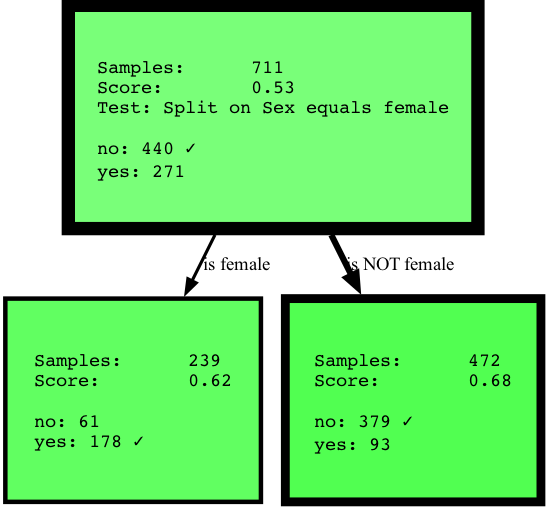

In [48]:
display.Image(model_1)

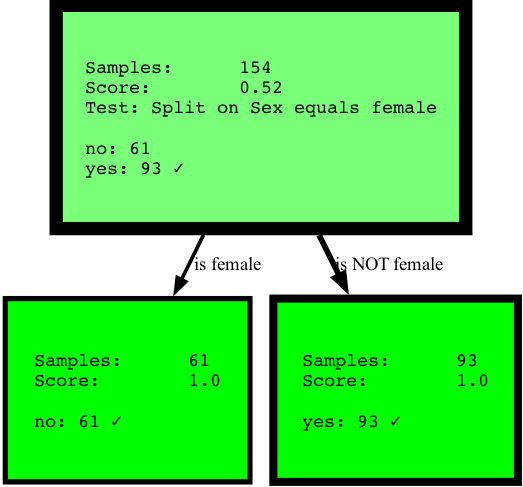

In [49]:
display.Image(model_2)

## (ii) inspect the specialization
Notice how the models are just one split and it both times splits on `Sex` while having different outcomes?
This is because the models are specialized on a different subset of the data
You can inspect this by following path to the `Expert` leaves


In [50]:
specialization_1 = trex.assignment_trees_[0].generate_dot_graph().pipe("png")

In [51]:
specialization_2 = trex.assignment_trees_[1].generate_dot_graph().pipe("png")

Specialization of expert #1


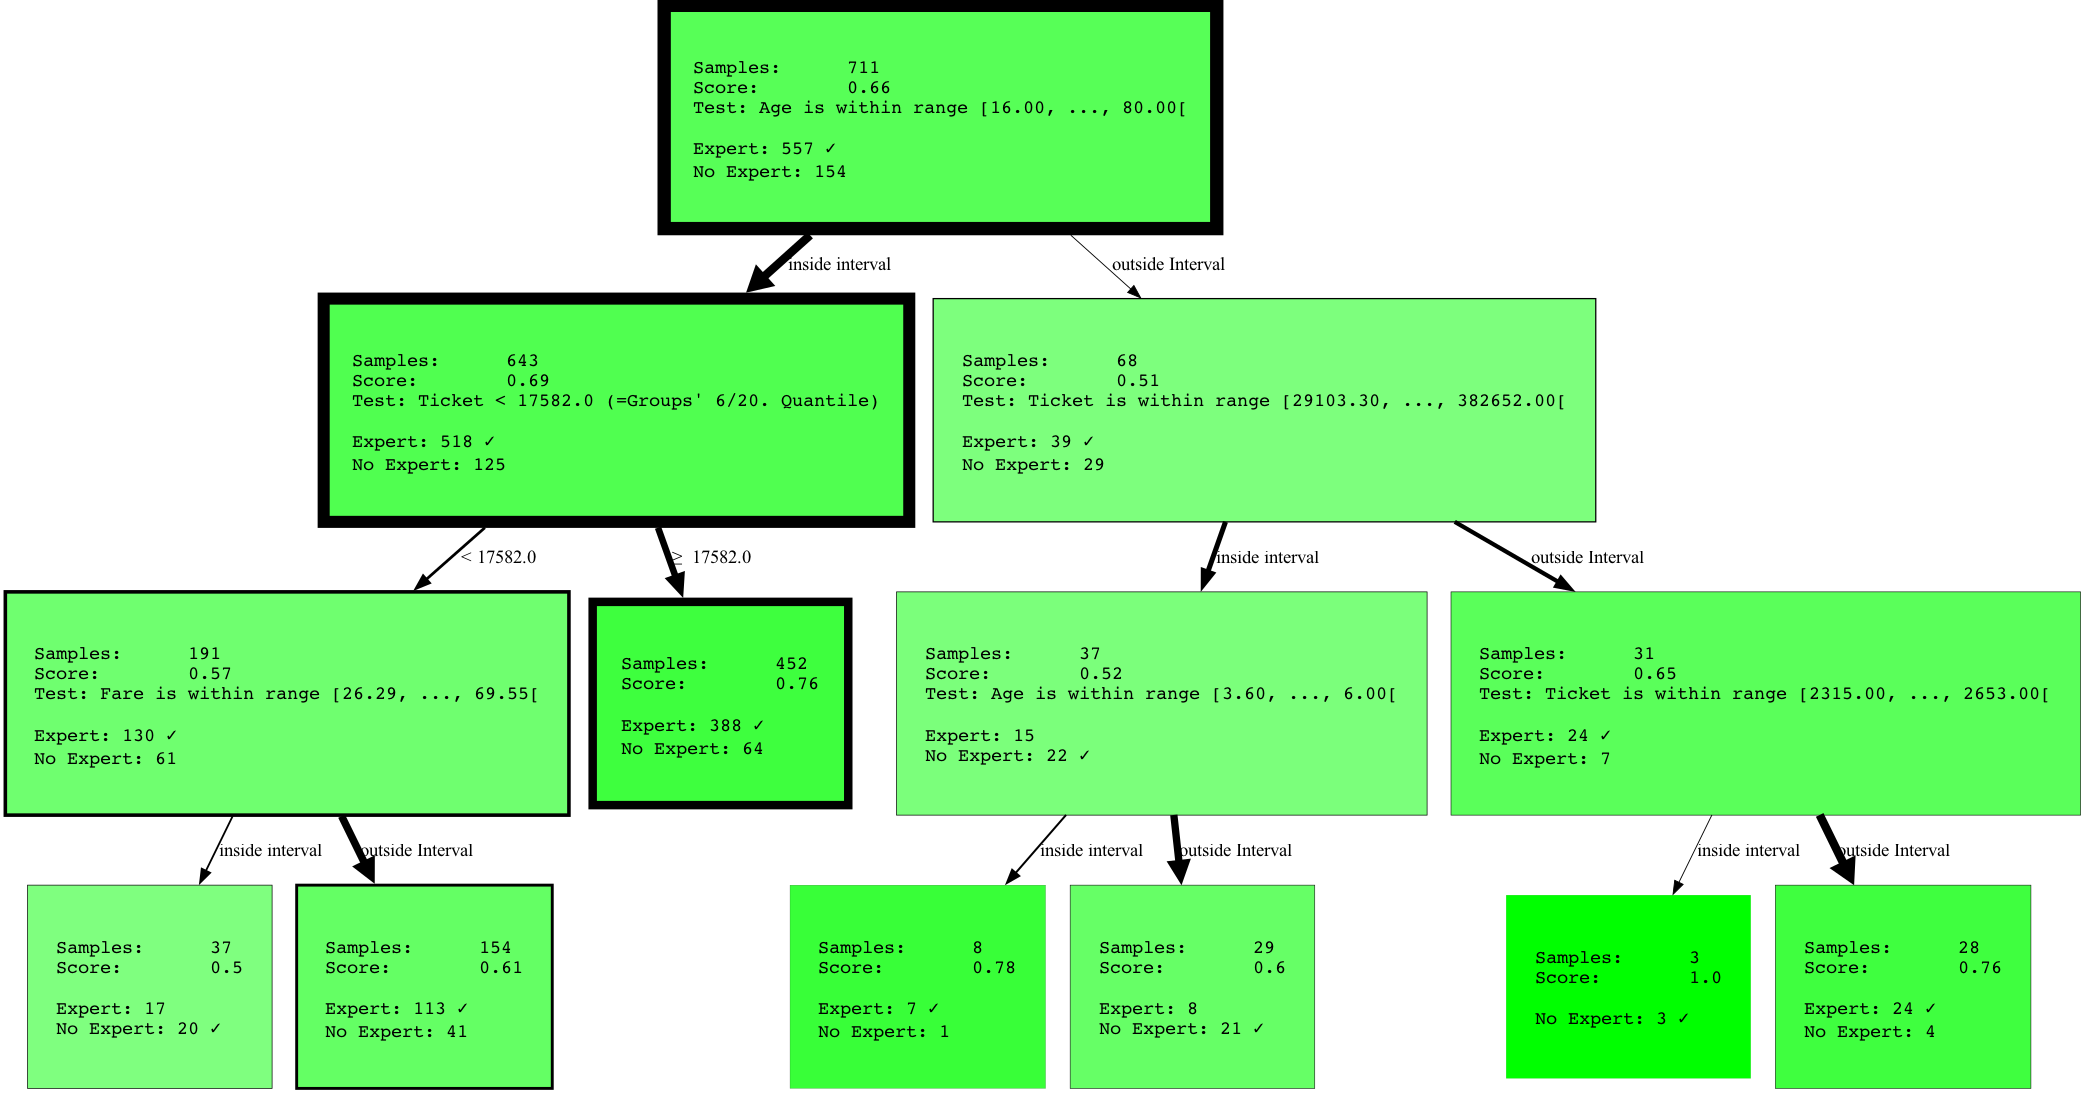

In [52]:
print("Specialization of expert #1")
display.Image(specialization_1)

Specialization of expert #2


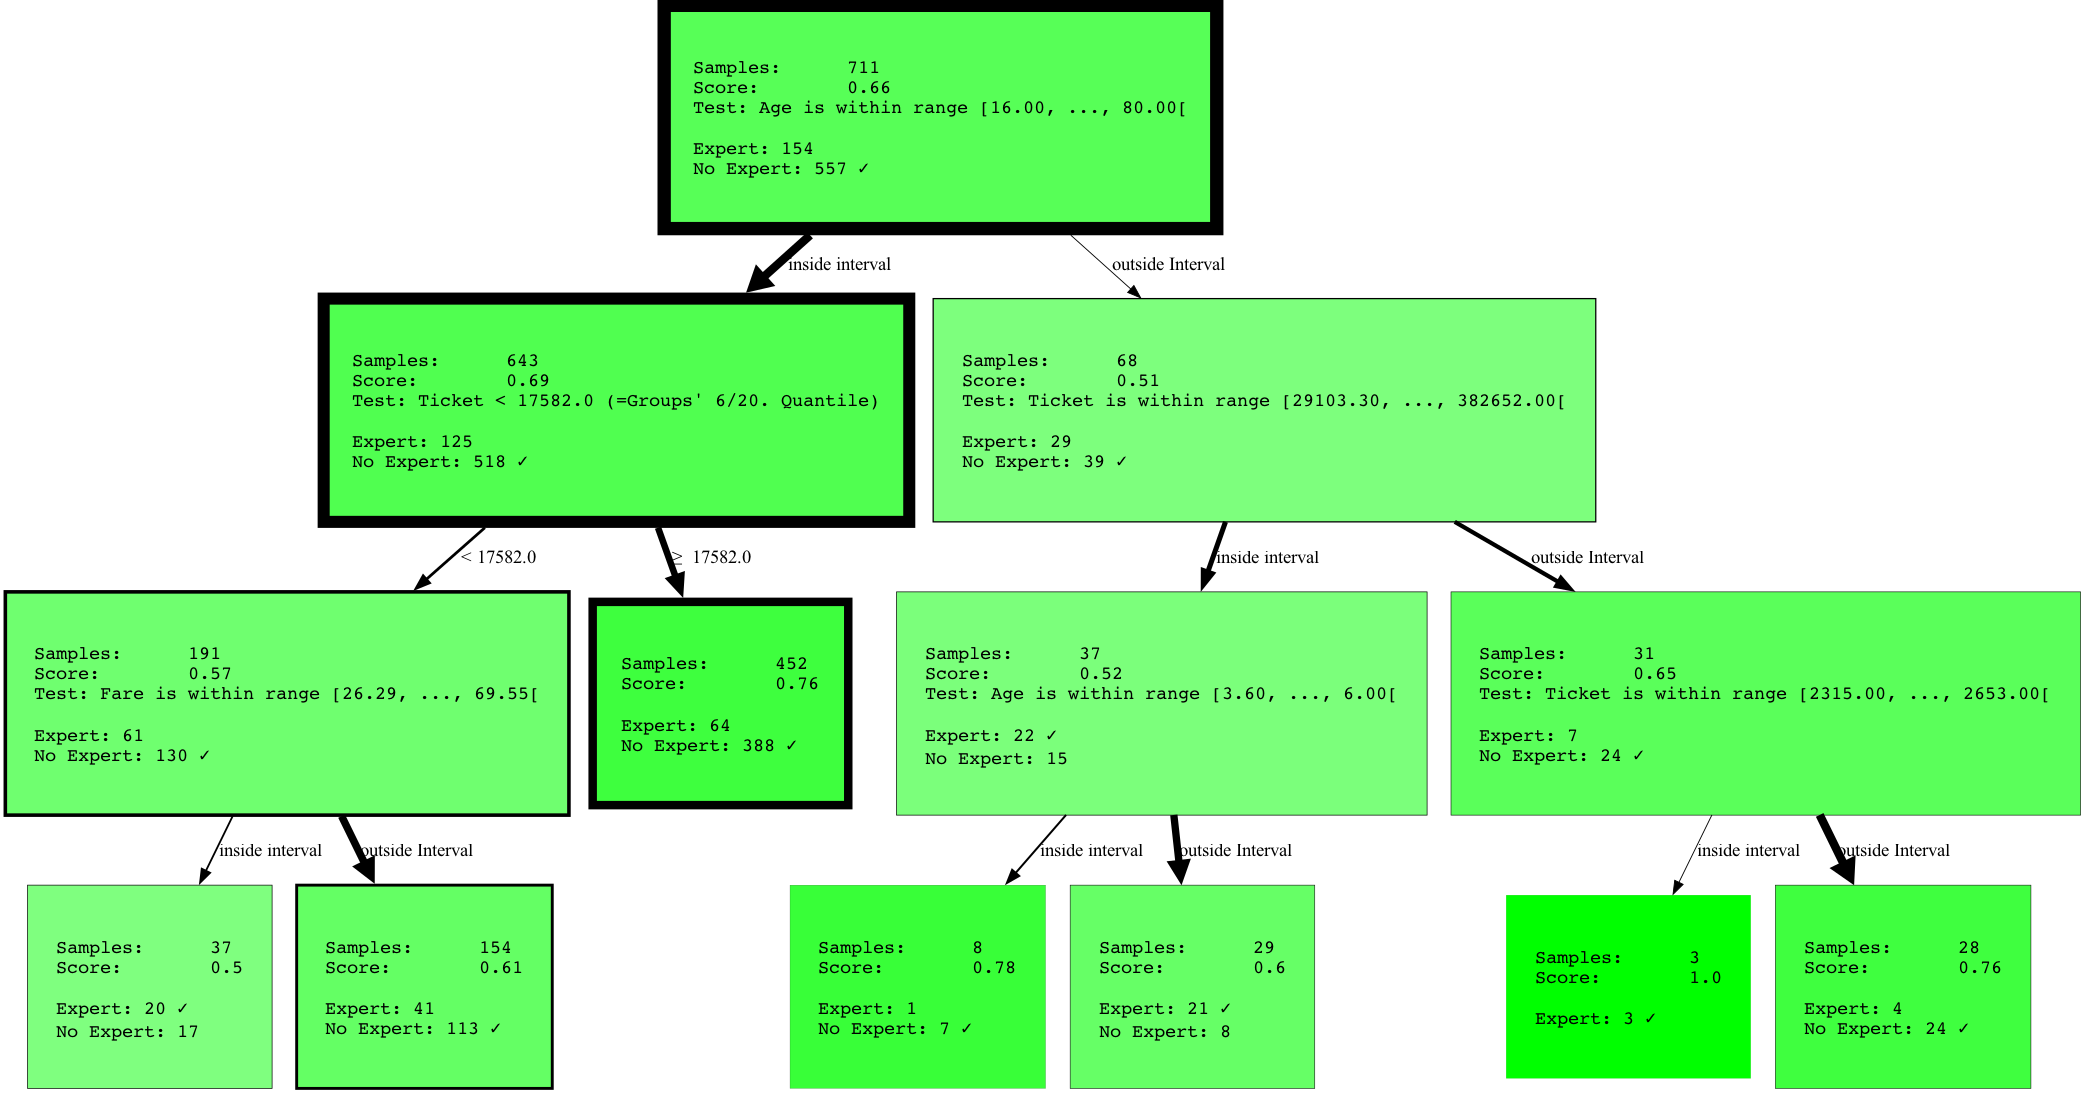

In [133]:
print("Specialization of expert #2")
display.Image(specialization_2)

## Non-simplified trees
Note that the experts above were sourced from the simplified tree, thus being only one level. You might want to gather information from non-simplified trees for information mining.

Although eventually, the decision stays exactly the same when departing from the first node in either of the versions, we can observe that on both sides of the tree the probability of survival still changes depending on the Passenger Class (`Pclass`)

In [56]:
tree_1_not_simplified = trex_not_simplified.pool_classifiers_[0].generate_dot_graph().pipe("png")

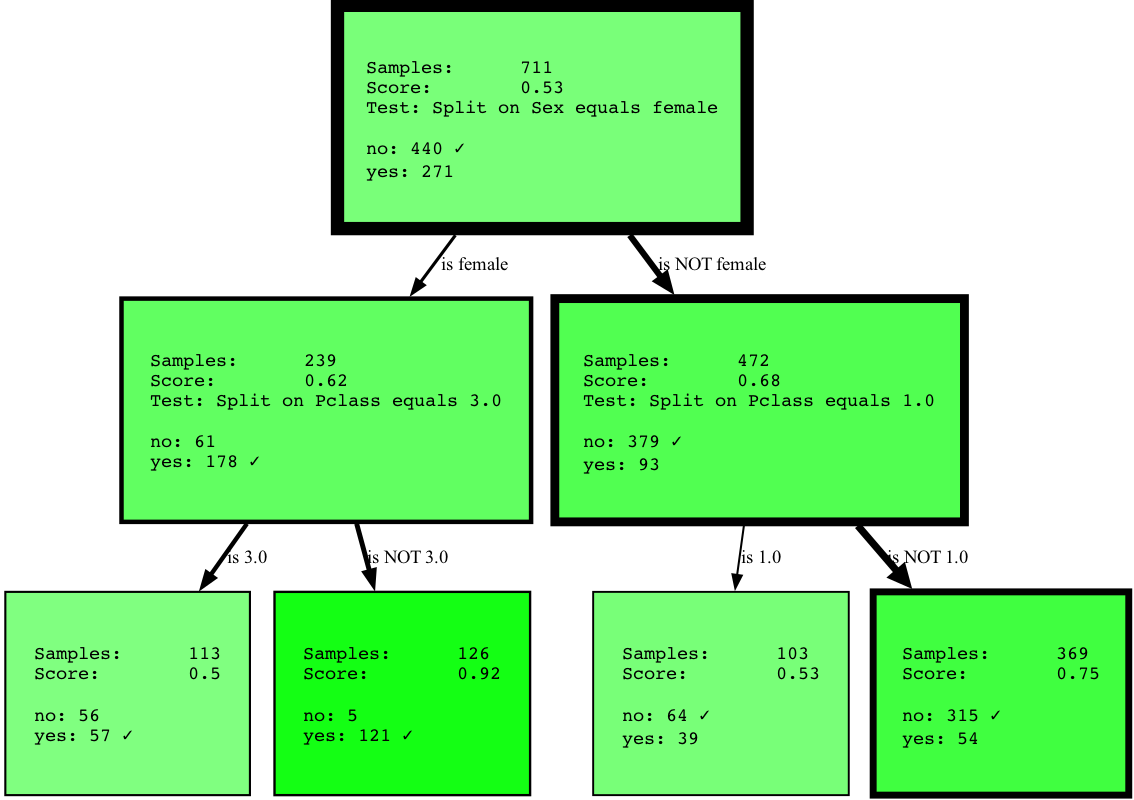

In [57]:
display.Image(tree_1_not_simplified)